In [34]:
from datasets import load_dataset
import pandas as pd
import numpy as np

In [35]:
dataset = load_dataset("imdb")
dataset

Found cached dataset imdb (/Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 88.11it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## Features

### Preprocessing

In [36]:
from string import punctuation
import re

def preprocess(dataset: pd.DataFrame) -> pd.DataFrame :
    """
    Preprocess the dataset by lowercasing the text and removing the punctuation manually

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to preprocess

    Returns
    -------
    pd.DataFrame
        The preprocessed dataset
    """
    # First lower the case
    dataset["document"] = dataset["document"].apply(lambda x: x.lower())
    # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
    # Replace HTML tag <br />
    punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!", punctuation)), reverse=True)))
    print(f"Deleting all these punctuation: {punctuation_to_remove}")
    dataset["document"] = dataset["document"].apply(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")))
    return dataset

In [37]:
train_raw = pd.DataFrame(dataset["train"], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
preprocessed_train = preprocess(train_raw)

test_raw = pd.DataFrame(dataset["test"], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
preprocessed_test = preprocess(test_raw)
preprocessed_train, preprocessed_test

Deleting all these punctuation: \~|\}|\||\{|`|_|\^|\]|\\|\[|@|\?|>|=|<|;|:|/|\.|,|\+|\*|\)|\(|\&|%|\$|\#|"
Deleting all these punctuation: \~|\}|\||\{|`|_|\^|\]|\\|\[|@|\?|>|=|<|;|:|/|\.|,|\+|\*|\)|\(|\&|%|\$|\#|"


(                                                document  class
 0      i rented i am curious-yellow from my video sto...      0
 1       i am curious  yellow  is a risible and preten...      0
 2      if only to avoid making this type of film in t...      0
 3      this film was probably inspired by godard's ma...      0
 4      oh  brother   after hearing about this ridicul...      0
 ...                                                  ...    ...
 24995  a hit at the time but now better categorised a...      1
 24996  i love this movie like no other  another time ...      1
 24997  this film and it's sequel barry mckenzie holds...      1
 24998  'the adventures of barry mckenzie' started lif...      1
 24999  the story centers around barry mckenzie who mu...      1
 
 [25000 rows x 2 columns],
                                                 document  class
 0      i love sci-fi and am willing to put up with a ...      0
 1      worth the entertainment value of a rental  esp...    

Load lexicon and keep only interesting tokens (one above the treshold)

In [10]:
threshold = 1
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token")
lexicon = lexicon[(lexicon["Score"] <= -threshold) | (lexicon["Score"] >= threshold)]
lexicon

,Score
Token,
$:,-1.5
%-),-1.5
( '}{' ),1.6
('-:,2.2
(':,2.3
...,...
|^:,-1.1
||-:,-2.3
}:,-2.1


Generate the following features:
- 1 if "no" appears in the document, 0 otherwise.
- The count of first and second pronouns in the document.
- 1 if "!" is in the document, 0 otherwise.
- Log(word count in the document).
- Number of words in the document which are in the positive lexicon.
- Number of words in the document which are in the negative lexicon.
- [Bonus] Add another feature of your choice.

In [11]:
# Generate the following features:
# - 1 if "no" appears in the document, 0 otherwise.
# - The count of first and second pronouns in the document.
# - 1 if "!" is in the document, 0 otherwise.
# - Log(word count in the document).
# - Number of words in the document which are in the positive lexicon.
# - Number of words in the document which are in the negative lexicon.
# - [Bonus] Add another feature of your choice.

def is_in_lexicon(word: str, positive: bool):
    try:
        score = lexicon.at[word, "Score"].item()
        return score >= threshold if positive else score <= -threshold
    except:
        return False

def generate_features(dataset: pd.DataFrame) -> pd.DataFrame :
    """
    Generate the features for the dataset

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to generate the features for

    Returns
    -------
    pd.DataFrame
        The dataset with the features
    """
    dataset["no"] = dataset["document"].apply(lambda x: 1 if "no" in x.split(" ") else 0)
    dataset["pronouns"] = dataset["document"].apply(lambda x: x.split(" ")).apply(lambda x: x.count("i") + x.count("we") + x.count("you"))
    dataset["exclamation"] = dataset["document"].apply(lambda x: 1 if "!" in x else 0)
    dataset["log_word_count"] = dataset["document"].apply(lambda x: np.log(len(x.split(" "))))
    dataset["positive_lexicon"] = dataset["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, True), x.split(" ")))))
    dataset["negative_lexicon"] = dataset["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, False), x.split(" ")))))

    # add feature vector column
    dataset["feature_vector"] = dataset.apply(lambda x: [x["no"], x["pronouns"], x["exclamation"], x["log_word_count"], x["positive_lexicon"], x["negative_lexicon"]], axis=1)
    # drop the other columns
    dataset = dataset.drop(columns=["no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"])

    return dataset

In [21]:
reduced_train = preprocessed_train.iloc[::10].copy()
reduced_train = generate_features(reduced_train)
reduced_train

,document,class,feature_vector
0,i rented i am curious-yellow from my video sto...,0,"[1, 11, 0, 5.739792912179234, 7, 6]"
10,it was great to see some of my favorite stars ...,0,"[1, 9, 0, 5.680172609017068, 14, 4]"
20,if the crew behind zombie chronicles ever re...,0,"[1, 9, 0, 5.327876168789581, 9, 2]"
30,i have not seen many low budget films i must a...,0,"[0, 7, 0, 5.209486152841421, 8, 7]"
40,i have read all of the love come softly books ...,0,"[0, 5, 0, 5.0106352940962555, 5, 3]"
...,...,...,...
24950,i definitely recommend reading the book prior ...,1,"[0, 6, 1, 5.703782474656201, 14, 3]"
24960,i used to watch this show when i was a little ...,1,"[0, 14, 0, 5.123963979403259, 9, 0]"
24970,i've seen this movie and i must say i'm very i...,1,"[0, 13, 0, 5.0689042022202315, 13, 2]"
24980,i was pleased to see that she had black hair! ...,1,"[0, 8, 1, 5.049856007249537, 9, 3]"


In [14]:
reduced_test = preprocessed_test.iloc[::10].copy()

reduced_test = generate_features(reduced_test)
reduced_test

,document,class,feature_vector
0,i love sci-fi and am willing to put up with a ...,0,"[0, 5, 1, 5.62040086571715, 9, 8]"
10,this flick is a waste of time i expect from an...,0,"[1, 1, 0, 4.948759890378168, 3, 12]"
20,low budget horror movie if you don't raise yo...,0,"[0, 6, 1, 5.225746673713202, 10, 7]"
30,lowe returns to the nest after yet another f...,0,"[0, 4, 1, 5.459585514144159, 8, 9]"
40,i can't believe the high marks people have giv...,0,"[0, 6, 1, 5.6240175061873385, 8, 9]"
...,...,...,...
24950,especially by lambert this is the essential...,1,"[0, 8, 0, 5.10594547390058, 8, 3]"
24960,watch it with an open mind it is very differe...,1,"[0, 1, 0, 4.02535169073515, 4, 0]"
24970,slipknot is a heavy metal band from the great ...,1,"[0, 8, 0, 5.117993812416755, 6, 1]"
24980,this film is just plain lovely it's funny as ...,1,"[0, 3, 1, 4.912654885736052, 5, 2]"


In [45]:
preprocessed_train = generate_features(preprocessed_train)
print("Train set generated")
preprocessed_test = generate_features(preprocessed_test)
print("Test set generated")

Train set generated
Test set generated


## Logistic regression classifier

In [23]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [68]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [69]:
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

Split the data into training and test sets.

In [62]:
features_train = preprocessed_train["feature_vector"]
# convert to numpy array 2d
features_train = np.array(features_train.to_list())
labels_train = preprocessed_train["class"].to_numpy()

features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    features_train,
    labels_train,
    test_size=0.15,
    stratify=labels_train,
    random_state=42,
)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

(torch.Size([21250, 6]),
 torch.Size([3750, 6]),
 torch.Size([21250, 1]),
 torch.Size([3750, 1]))

In [63]:
# Let's do the same feature engineering for the test set
features_test = preprocessed_test["feature_vector"]
features_test = np.array(features_test.to_list())
X_test = torch.tensor(features_test, dtype=torch.float32)

labels_test = preprocessed_test["class"].to_numpy()
y_test = torch.tensor(labels_test, dtype=torch.float32).reshape(-1, 1)

X_test.shape, y_test.shape

(torch.Size([25000, 6]), torch.Size([25000, 1]))

In [70]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(2.8912, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5868, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5859, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5850, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5849, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5848, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5848, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5848, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5848, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
CPU times: user 680 ms, sys: 176 ms, total: 856 ms
Wall time: 597 ms


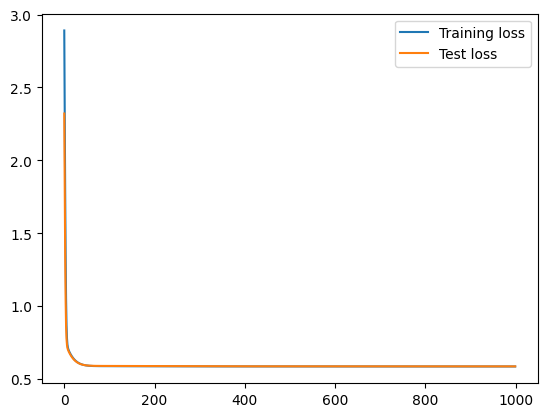

In [71]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [72]:
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.7152 0.7 0.71408


In [77]:
# Look at the weights of your classifier. Which features seems to play most for both classes ?

# Let's look at the weights of the linear layer
weights = model.linear.weight.detach().numpy()
print(weights)
print(np.argmax(weights))

[[-0.02932489 -0.02839465 -0.00931369 -0.02108636  0.12831183 -0.15112449]]
4


The feature playing the most important role in the classification is the number of words in the document which are in the positive lexicon. This is not surprising as the positive lexicon contains words such as "good", "great", "excellent", etc. which are very indicative of a positive review.

In [91]:
# Take two wrongly classified samples in the test set and try explaining why the model was wrong.

# Let's look at the wrongly classified samples
wrongly_classified = np.where(p_test != y_test.numpy())[0]
print(wrongly_classified)

# Let's look at the first wrongly classified sample
print(preprocessed_test.iloc[wrongly_classified[0]]["document"], preprocessed_test.iloc[wrongly_classified[0]], sep="\n")

# Let's look at the second wrongly classified sample
print(preprocessed_test.iloc[wrongly_classified[1]]["document"], preprocessed_test.iloc[wrongly_classified[1]], sep="\n")

[    4     6    11 ... 24991 24998 24999]
first off let me say  if you haven't enjoyed a van damme movie since bloodsport  you probably will not like this movie  most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are  this movie is much better than any of the movies the other action guys  segal and dolph  have thought about putting out the past few years  van damme is good in the movie  the movie is only worth watching to van damme fans  it is not as good as wake of death  which i highly recommend to anyone of likes van damme  or in hell but  in my opinion it's worth watching  it has the same type of feel to it as nowhere to run  good fun stuff!
document          first off let me say  if you haven't enjoyed a...
class                                                             0
feature_vector                  [0, 6, 1, 4.997212273764115, 12, 2]
Name: 4, dtype: object
isaac florentine has made some of the best western martial

These wrondly classified examples are mostly positive reviews which are classified as negative. This is surely because they are really hard to classify, mixing positive and negative parts. In the first one: 'if you haven't enjoyed a van damme movie since bloodsport you probably will not like this movie' is negative when read on its own, but positive when read in the context of the whole review. The second one also contains negative or mixed parts inside the whole review, which is very confusing for the classifier.